# Credit Risk Modeling | Part 3: Loss Given Default, Exposure at Default and Expected Loss

<img src="http://www.alll.com/wp-content/uploads/2015/11/pdlgd1.png">

**Loss given default (LGD)**  

LGD is the amount outstanding we expect to lose. It is a proportion of the total exposure when borrower defaults. It is a percentage of total exposure at the time of default or a single dollar value of potential loss. It is calculated by (1 - Recovery Rate). 

**Exposure at default (EAD)**  

EAD is the predicted amount of loss a bank is exposed to.  

**Expected Loss**  

EL =  PD x EAD  x LGD



# 1 Data Preparation

## a Import Libraries






In [1]:
#installing gdown package to download dataset stored in G Drive
!pip install gdown

# to upgrade
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

#libs for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#ML model
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score

import scipy.stats as stat

#exporting ML model
import pickle

#lib to download dataset on g drive
import gdown

#setting display option max rows
#pd.options.display.max_rows = None

## b Import Data

Please note that if you have already run the first notebook of this series, you don't need to run the codes below and so download the data sets.

In [4]:
# 1st file
url = "https://drive.google.com/file/d/1v45P0HhUxZ1x4HmD0bWblpUyUWuiC0_5/view?usp=share_link"
output = "loan_data_inputs_train.csv"
g_down (url,output)

# 2nd file
url = "https://drive.google.com/file/d/1KvP7EXfVNdekotGFqgp9UUlNXBLCKy9i/view?usp=share_link"
output = "loan_data_targets_train.csv"
g_down (url,output)

Downloading...
From: https://drive.google.com/uc?id=1v45P0HhUxZ1x4HmD0bWblpUyUWuiC0_5
To: /content/loan_data_inputs_train.csv
100%|██████████| 436M/436M [00:02<00:00, 159MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KvP7EXfVNdekotGFqgp9UUlNXBLCKy9i
To: /content/loan_data_targets_train.csv
100%|██████████| 3.27M/3.27M [00:00<00:00, 100MB/s]


In [5]:

# 3rd file
url = "https://drive.google.com/file/d/1M-VHZM612ihx-elO6dw3SVYJh0cWD5E6/view?usp=share_link"
output = "loan_data_inputs_test.csv"
g_down (url,output)

# 4th file
url = "https://drive.google.com/file/d/1wTkfTDyCxcMcddsz-Fk-AO_Y6owLhzWp/view?usp=share_link"
output = "loan_data_targets_test.csv"
g_down (url,output)


Downloading...
From: https://drive.google.com/uc?id=1M-VHZM612ihx-elO6dw3SVYJh0cWD5E6
To: /content/loan_data_inputs_test.csv
100%|██████████| 109M/109M [00:01<00:00, 86.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wTkfTDyCxcMcddsz-Fk-AO_Y6owLhzWp
To: /content/loan_data_targets_test.csv
100%|██████████| 817k/817k [00:00<00:00, 19.4MB/s]


In [6]:
#import data
df1 = pd.read_csv("loan_data_inputs_train.csv", index_col = 0)
df2 = pd.read_csv("loan_data_inputs_test.csv", index_col = 0)
loan_data_preprocessed  = pd.concat([df1,df2],axis=0) #'loan_data_2007_2014_preprocessed.csv')
df1, df2 = [], [] #deleting the df s that use a large amount of ram source

## c Filtering defaulted account data

In [7]:
# We only need the data on the accounts that were charged-off (written-off).
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].\
                                            isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]

In [8]:
loan_data_defaults.shape

(43236, 315)

##d Independent Variables

In [9]:
# Let's fill missing values with zeroes.
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [10]:
# Let's fill the missing values with zeroes.
loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)

## e Dependent Variables

### i- Recovery rate

In [11]:
# For the LGD model, We need to calculate the dependent variable recovery rate.
# It is the ratio of recoveries and funded amount.
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']

<ipython-input-11-474190805694>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']


In [12]:
# Let's check out some descriptive statisics for the values of a column.
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [13]:
# We have some recovery rate data > 1.0.
# We need to set recovery rates that are greater than 1 to 1 
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
# We need to set recovery rates that are less than 0 to 0. (this part is kept for a future dataset)
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])


<ipython-input-13-48e53ac265c0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
<ipython-input-13-48e53ac265c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])


In [14]:
#let's check if all is good after data cleaning
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

### ii- CCF

In [15]:
# let's calculate the dependent variable for the EAD model: credit conversion factor.
# It is the ratio of the difference of the amount used at the moment of default to the total funded amount.
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - \
                             loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']


<ipython-input-15-d3c02e470742>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - \


In [16]:
loan_data_defaults['CCF'].describe()
# Shows some descriptive statisics for the values of a column.

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

(array([  10.,   21.,   49.,   21.,   51.,   54.,   21.,  103.,   30.,
          93.,   73.,   62.,   96.,   63.,  135.,   99.,  116.,  145.,
         125.,  162.,  140.,  178.,  162.,  178.,  213.,  194.,  228.,
         209.,  258.,  248.,  275.,  263.,  295.,  326.,  372.,  312.,
         409.,  367.,  382.,  420.,  454.,  475.,  528.,  525.,  515.,
         573.,  554.,  655.,  636.,  718.,  742.,  861.,  809.,  965.,
         873., 1105., 1033., 1182., 1130., 1270., 1317., 1360., 1477.,
        1327., 1715., 1457., 1803., 1463., 1874., 1520., 1393., 1568.,
         750.,  999.,  652.]),
 array([4.38000000e-04, 1.37654933e-02, 2.70929867e-02, 4.04204800e-02,
        5.37479733e-02, 6.70754667e-02, 8.04029600e-02, 9.37304533e-02,
        1.07057947e-01, 1.20385440e-01, 1.33712933e-01, 1.47040427e-01,
        1.60367920e-01, 1.73695413e-01, 1.87022907e-01, 2.00350400e-01,
        2.13677893e-01, 2.27005387e-01, 2.40332880e-01, 2.53660373e-01,
        2.66987867e-01, 2.80315360e-01, 2

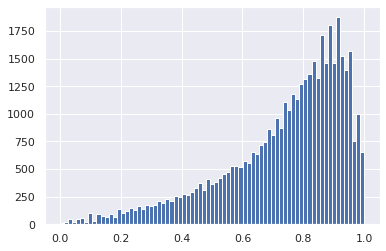

In [17]:
# Plotting a histogram of CCF
plt.hist(loan_data_defaults['CCF'], bins = 75)

In [18]:
# Creating a new variable showing 0 for recovery rate being 0 and 1 otherwise.
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)

<ipython-input-18-c5132e951376>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)


## f Exporting data

In [19]:
#saving the data in a csv file
loan_data_defaults.to_csv('../data/loan_data_defaults.csv')

#2 LGD Model

LGD is the amount outstanding we expect to lose. It is a proportion of the total exposure when borrower defaults. It is a percentage of total exposure at the time of default or a single dollar value of potential loss. It is calculated by (1 - Recovery Rate). 

The model will be created in two steps:
*  Step 1- recovery rate is equal to/greater than 0

*  Step 2- recovery rate is equal to/greater than 1

### a Step 1 --- Logistic Regression

In [20]:
# LGD model step 1 datasets: recovery rate 0 or greater than 0.
# Considering a set of inputs [all cols except recovery rate and CCF] and outputs[recovery_rate_0_1]. Splits the inputs and the targets into four dataframes:
# Inputs - Train n Test, Targets - Train n Test
lgd_X_S1 = loan_data_defaults.drop([ 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1)
lgs_Y_S1 = loan_data_defaults['recovery_rate_0_1']

lgd_X_S1_train, lgd_X_S1_test, lgd_Y_S1_train, lgd_Y_S1_test = train_test_split(lgd_X_S1, lgs_Y_S1, test_size = 0.2, random_state = 42)

In [21]:
# List of all X variables for the models.
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [22]:
# List of the dummy X variables, avoiding dummy trick reference categories. 
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']


In [23]:
# Here we keep only the variables we need for the model.
lgd_X_S1_train = lgd_X_S1_train[features_all]
# Here we remove the dummy variable reference categories.
lgd_X_S1_train = lgd_X_S1_train.drop(features_reference_cat, axis = 1)


In [24]:
lgd_X_S1_train.isnull().sum()
# Check for missing values. We check whether the value of each row for each column is missing or not,
# then sum accross columns.

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

In [26]:
# We create an instance of an object from the 'LogisticRegression' class.
reg_lgd_st_1 = LogisticRegression_with_p_values()

# Estimating the coefficients of the object from the 'LogisticRegression' class
# with X (independent variables) from the first dataframe
# and Y (dependent variables) from the second dataframe.
reg_lgd_st_1.fit(lgd_X_S1_train, lgd_Y_S1_train)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:

# Stores the names of the columns of a dataframe in a variable.
feature_name = lgd_X_S1_train.columns.values

In [28]:
# Creating a df with a column 'Feature name' and values of the 'feature_name' variable.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a new column called 'Coefficients',
# with row values the transposed coefs from the 'LogisticRegression' object.
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
# Increasing the index of every row of the df with 1.
summary_table.index = summary_table.index + 1
# Assigning values of the row with index 0 of the df.
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
# Sorts the df by index.
summary_table = summary_table.sort_index()
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = reg_lgd_st_1.p_values
# We add the value 'NaN' in the beginning of the variable with p-values.
p_values = np.append(np.nan,np.array(p_values))
# In the 'summary_table' df, we add a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table['p_values'] = p_values

summary_table

,Feature name,Coefficients,p_values
0,Intercept,-8.109924e-05,NaN
1,grade:A,-1.784447e-05,9.998330e-01
2,grade:B,-6.594759e-05,9.992320e-01
3,grade:C,-1.249210e-04,9.984856e-01
4,grade:D,1.168450e-05,9.998636e-01
5,grade:E,3.166267e-05,9.996646e-01
6,grade:F,7.347620e-05,9.993251e-01
7,home_ownership:MORTGAGE,-4.543531e-05,9.985820e-01
8,home_ownership:NONE,1.285601e-06,9.999989e-01
9,home_ownership:OTHER,1.147944e-06,9.999979e-01


### b Step 1 ---Testing the Model

In [29]:
# Here we keep only the variables [features_all] that we need for the model.
lgd_X_S1_test = lgd_X_S1_test[features_all]
# Then we remove the dummy variable reference categories.
lgd_X_S1_test = lgd_X_S1_test.drop(features_reference_cat, axis = 1)

In [30]:
# Calculating the predicted vals for the Y (targets) given X (inputs)
y_hat_test_lgd_step_1 = reg_lgd_st_1.model.predict(lgd_X_S1_test)

In [31]:
y_hat_test_lgd_step_1

array([0, 1, 1, ..., 1, 1, 1])

In [32]:
# Calculates the predicted probability for Y (targets) given X (inputs)
y_hat_test_proba_lgd_step_1 = reg_lgd_st_1.model.predict_proba(lgd_X_S1_test)

In [33]:
# arrays of predicted class probabilities
# first val of arrays  is the probability for the observation belonging to the first class, i.e. 0,
# and the second value is the probability for the observation belonging to 1
y_hat_test_proba_lgd_step_1

array([[0.56074912, 0.43925088],
       [0.40487422, 0.59512578],
       [0.38201719, 0.61798281],
       ...,
       [0.43472837, 0.56527163],
       [0.35297444, 0.64702556],
       [0.37926079, 0.62073921]])

In [34]:
# we consider only the probabilities for being 1.
y_hat_test_proba_lgd_step_1 = y_hat_test_proba_lgd_step_1[: ][: , 1]

In [35]:
y_hat_test_proba_lgd_step_1

array([0.43925088, 0.59512578, 0.61798281, ..., 0.56527163, 0.64702556,
       0.62073921])

In [36]:
lgd_Y_S1_test_temp = lgd_Y_S1_test

In [37]:
# resetting the index of a dataframe.
lgd_Y_S1_test_temp.reset_index(drop = True, inplace = True)

In [38]:
# Concatenating two dataframes.
df_actual_predicted_probs = pd.concat([lgd_Y_S1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_step_1)], axis = 1)

In [39]:
df_actual_predicted_probs.columns = ['lgd_targets_step_1_test', 'y_hat_test_proba_lgd_step_1']

In [40]:
# Making the indices eqv to each other
df_actual_predicted_probs.index = lgd_X_S1_test.index

In [41]:
df_actual_predicted_probs.head()

,lgd_targets_step_1_test,y_hat_test_proba_lgd_step_1
273771,1,0.439251
353045,0,0.595126
437319,0,0.617983
193344,1,0.644178
173478,0,0.674074


### c Step 1 --- Estimating the Аccuracy of the Мodel

In [42]:
tr = 0.5
# Indicator column created to give '1' for the cases where predicted proba is greater than threshold
df_actual_predicted_probs['y_hat_test_lgd_step_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_step_1'] > tr, 1, 0)

In [43]:
# Creating a cross-table, a Confusion Matrix where the actual vals are displayed by rows and the predicted vals by columns.
pd.crosstab(df_actual_predicted_probs['lgd_targets_step_1_test'], df_actual_predicted_probs['y_hat_test_lgd_step_1'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,1203,2615
1,885,3945


In [44]:
# Gettign rates by dividing values by the tot number of observations,
cmatrix_p = pd.crosstab(df_actual_predicted_probs['lgd_targets_step_1_test'], \
                        df_actual_predicted_probs['y_hat_test_lgd_step_1'], \
                        rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]
cmatrix_p

Predicted,0,1
Actual,,
0,0.139107,0.302382
1,0.102336,0.456175


In [45]:
# Calculating accuracy of the model = sum of the diagonal rates.
cmatrix_p.iloc[0, 0] + cmatrix_p.iloc[1, 1]

0.5952821461609621

In [46]:
# Getting Receiver Operating Characteristic (ROC) Curve: the false positive rates, the true positive rates, and the thresholds.
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_step_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_step_1'])


Text(0.5, 1.0, 'ROC curve')

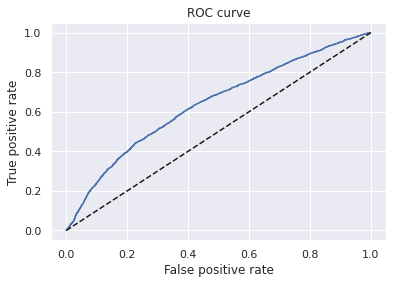

In [47]:
# We plot the ROC: false positive rate along the x-axis and the true positive rate along the y-axis,
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [48]:
# Calculating the Area Under the Receiver Operating Characteristic Curve (AUROC)
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_step_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_step_1'])
AUROC

0.6401916605118828

ROC being 0.64 shows a better performance of 1:1 line, a dummy model of probability of 0.50. We keep the trained model.

### d Step 1 --- Saving the Model

In [49]:
# Exporting our model to a 'SAV' file
pickle.dump(reg_lgd_st_1, open('../models/lgd_model_step_1.sav', 'wb'))

### e Step 2 --- Linear Regression

In [50]:
# Here we take only rows where the original recovery rate variable is greater than one,
# i.e. where the indicator variable we created is equal to 1.
lgd_step_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

In [51]:
# LGD model stage 2 datasets: how much more than 0 is the recovery rate
lgd_X_S2 = lgd_step_2_data.drop([ 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1)
lgd_Y_S2 = lgd_step_2_data['recovery_rate']
# splitting Inputs - Train + Test and  Targets - Train + Test.
lgd_X_S2_train, lgd_X_S2_test, lgd_Y_S2_train, lgd_Y_S2_test = train_test_split(lgd_X_S2, lgd_Y_S2, test_size = 0.2, random_state = 42)
# freeing the memory used by following arrays
lgd_x_S2, lgd_Y_S2  = [],[]

In [53]:
# keeping the variables needed for the model.
lgd_X_S2_train = lgd_X_S2_train[features_all]
# removing the dummy variable reference categories.
lgd_X_S2_train = lgd_X_S2_train.drop(features_reference_cat, axis = 1)

In [54]:
# creating an instance of an object from the 'LogisticRegression' class.
reg_lgd_st_2 = LinearRegression()
# Estimating the coeffs w X_train and Y_train
reg_lgd_st_2.fit(lgd_X_S2_train, lgd_Y_S2_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression()

In [55]:
# Storing the names of the columns
feature_name = lgd_X_S2_train.columns.values

In [56]:
# Creating a df with a column 'Feature name' and vals in 'feature_name'
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creating a new column 'Coefficients' w row values the transposed coefficients from the 'LogisticRegression' object.
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
# Increasing the index of every row of the dataframe with 1.
summary_table.index = summary_table.index + 1
# Assigning values of the row with index 0 of the dataframe.
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
# Sorting the dataframe by index.
summary_table = summary_table.sort_index()
# Taking the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = reg_lgd_st_2.p
# Adding the value 'NaN' in the beginning of the variable with p-values.
p_values = np.append(np.nan,np.array(p_values))
# Adding a column of 'p_values', containing the values
summary_table['p_values'] = p_values.round(3)

summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.596884e-01,NaN
1,grade:A,-8.542627e-02,0.000
2,grade:B,-6.188063e-02,0.000
3,grade:C,-4.839424e-02,0.000
4,grade:D,-3.485896e-02,0.000
5,grade:E,-1.903644e-02,0.000
6,grade:F,-1.049845e-02,0.029
7,home_ownership:MORTGAGE,2.436369e-03,0.101
8,home_ownership:NONE,1.435086e-01,0.000
9,home_ownership:OTHER,5.398011e-02,0.007


### f Step 2 --- Model Evaluation

In [57]:
# keeping the variables needed
lgd_X_S2_test = lgd_X_S2_test[features_all]

In [58]:
# Removing the dummy variable reference categories.
lgd_X_S2_test = lgd_X_S2_test.drop(features_reference_cat, axis = 1)

In [59]:
# Calculating the predicted vals for Y given X
lgd_X_S2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [60]:
# Predicting Y given X
y_hat_test_lgd_step_2 = reg_lgd_st_2.predict(lgd_X_S2_test)

In [61]:
lgd_Y_S2_test_temp = lgd_Y_S2_test

In [62]:
# Resetting the index of a dataframe.
lgd_Y_S2_test_temp = lgd_Y_S2_test_temp.reset_index(drop = True)


In [63]:
# Calculating the correlation between actual and predicted values.
pd.concat([lgd_Y_S2_test_temp, pd.DataFrame(y_hat_test_lgd_step_2)], axis = 1).corr()


,recovery_rate,0
recovery_rate,1.000000,0.286862
0,0.286862,1.000000


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


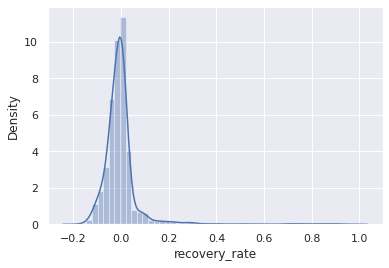

In [64]:
# Plotting the distribution of the residuals.
sns.distplot(lgd_Y_S2_test_temp - y_hat_test_lgd_step_2)


In [65]:
# Here we export our model
pickle.dump(reg_lgd_st_2, open('../models/lgd_model_step_2.sav', 'wb'))


### g Combining Steps 1 & 2

In [66]:
y_hat_test_lgd_step_2_all = reg_lgd_st_2.predict(lgd_X_S1_test)

In [67]:
y_hat_test_lgd_step_2_all

array([0.1663549 , 0.12969876, 0.11177816, ..., 0.13482666, 0.10030066,
       0.10221578])

In [68]:
# combining the predictions of the models from the two steps.y_hat_test_proba_lgd_step_1
y_hat_test_lgd = y_hat_test_lgd_step_1 * y_hat_test_lgd_step_2_all 

In [69]:
# Showing descriptive stats 
pd.DataFrame(y_hat_test_lgd).describe()


,0
count,8648.000000
mean,0.081082
std,0.052044
min,-0.004608
25%,0.031443
50%,0.097587
75%,0.120525
max,0.240395


In [70]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)
# We set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0.

In [71]:
pd.DataFrame(y_hat_test_lgd).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.081083
std,0.052042
min,0.000000
25%,0.031443
50%,0.097587
75%,0.120525
max,0.240395


#3 EAD Model

Exposure at default (EAD)

EAD is the predicted amount of loss a bank is exposed to.

### a Linear modeling and interpreation

In [72]:
# EAD model datasets
# Splitting into Inputs - Train n Test, Targets - Train n Test.
ead_X = loan_data_defaults.drop([ 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1)
ead_Y = loan_data_defaults['CCF']
ead_X_train, ead_X_test, ead_Y_train, ead_Y_test = train_test_split(ead_X, ead_Y, test_size = 0.2, random_state = 42)
ead_X, ead_Y = [],[]

In [73]:
ead_X_train.columns.values

array(['Unnamed: 0.1', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       've

In [74]:
# Keeping only the variables we need n removing the dummy var. reference categories.
ead_X_train = ead_X_train[features_all]
ead_X_train = ead_X_train.drop(features_reference_cat, axis = 1)

In [75]:
# Creating an instance of an object from the 'LogisticRegression' class.
reg_ead = LinearRegression()
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.
reg_ead.fit(ead_X_train, ead_Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression()

In [76]:
feature_name = ead_X_train.columns.values

In [77]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_ead.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.093109e+00,NaN
1,grade:A,-2.894280e-01,0.000000e+00
2,grade:B,-2.244236e-01,0.000000e+00
3,grade:C,-1.633793e-01,0.000000e+00
4,grade:D,-1.130644e-01,0.000000e+00
5,grade:E,-6.468983e-02,0.000000e+00
6,grade:F,-1.992519e-02,4.857475e-03
7,home_ownership:MORTGAGE,-6.689340e-03,1.415782e-03
8,home_ownership:NONE,2.396226e-02,7.533518e-01
9,home_ownership:OTHER,2.162196e-04,9.944750e-01


### b Model Validation

In [78]:
# keeping only the variables needed and removing dummy variables
ead_X_test = ead_X_test[features_all]
ead_X_test = ead_X_test.drop(features_reference_cat, axis = 1)

In [79]:
ead_X_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [80]:
# Calculating the predicted vals
y_hat_test_ead = reg_ead.predict(ead_X_test)

In [81]:
ead_Y_test_temp = ead_Y_test

In [82]:
ead_Y_test_temp = ead_Y_test_temp.reset_index(drop = True)
# We reset the index of a dataframe.

In [83]:
# Calculating the correlation between actual and predicted values.
pd.concat([ead_Y_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()


,CCF,0
CCF,1.000000,0.519019
0,0.519019,1.000000


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


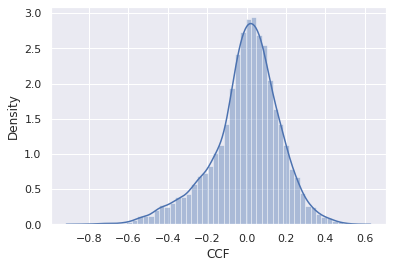

In [84]:
# Plotting the distribution of the residuals.
sns.distplot(ead_Y_test - y_hat_test_ead)

In [85]:
# Descriptive statisics for the values of a column.
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736497
std,0.104487
min,0.385745
25%,0.663073
50%,0.732534
75%,0.810746
max,1.008400


In [86]:
# Setting predicted values that are greater than 1 to 1 and vice versa
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)

In [87]:
# some descriptive statisics for the values of a column.
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736496
std,0.104484
min,0.385745
25%,0.663073
50%,0.732534
75%,0.810746
max,1.000000


#4 Expected Loss

In [88]:
#cleaning the memory
loan_data_preprocessed_backup = []

loan_data_defaults = []
lgd_X_S1_train, lgd_X_S1_test, lgd_Y_S1_train, lgd_Y_S1_test  = [], [],[],[]
lgd_step_2_data =[]
lgd_X_S2_train, lgd_X_S2_test, lgd_Y_S2_train, lgd_Y_S2_test = [],[],[],[]
ead_X_train, ead_X_test, ead_Y_train, ead_Y_test = [], [], [], []

In [89]:
# filling the missing values with zeroes.
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

In [90]:
# keeping the variables only we need for the model.
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]
# removing the dummy variable ref cats.
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

In [91]:
### 1- LGD MODELS ###
# using step 1 LGD model to calculate predicted values.
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)
# using step 2 LGD model to calculate predicted values.
loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [92]:
# Combining the predicted values from steps 1 + 2 to determine the final estimated recovery rate.
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']
# Setting estimated recovery rates greater than 1 to 1 and vice versa
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])

In [93]:
# Calculating estimated LGD. Estimated LGD equals 1 - estimated recovery rate.
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']
# Some descriptive statisics
loan_data_preprocessed['LGD'].describe()

count    466285.000000
mean          0.927799
std           0.058306
min           0.321313
25%           0.877418
50%           0.907896
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

In [94]:
### 2- EAD MODEL ###
# Applying EAD model to calculate estimated credit conversion factor.
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)

In [95]:
# Setting estimated CCF that are greater than 1 to 1 and vice versa
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])


In [96]:
# Estimated EAD = estimated CCF multiplied by funded amount.
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']
# Some descriptive statisics
loan_data_preprocessed['EAD'].describe()


count    466285.000000
mean      10799.244078
std        6911.759776
min         188.614188
25%        5498.707476
50%        9206.184808
75%       14664.481611
max       35000.000000
Name: EAD, dtype: float64

In [97]:
### 3- PD MODEL ###
# Importing data to apply the PD model.
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv')
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test.csv')

In [98]:
# Concating the two dfs
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)
# #clearing memeory
loan_data_inputs_train, loan_data_inputs_test = [],[] 

In [99]:
loan_data_inputs_pd.shape

(466285, 316)

In [100]:
loan_data_inputs_pd.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
0,427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,...,1,0,0,1,0,0,0,0,0,0
1,206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,...,0,0,0,1,0,0,0,0,0,0
2,136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,...,0,0,0,1,0,0,0,0,0,0
3,412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,...,0,0,0,1,0,0,0,0,0,0
4,36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,...,0,1,0,1,0,0,0,0,0,0


In [101]:
# Setting the index 
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')
loan_data_inputs_pd.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,1,0,0,0,0,0,0


In [102]:
# Here we select a limited set of input variables                                           
features_all_pd = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
#'mths_since_earliest_cr_line:<140',
#'mths_since_earliest_cr_line:141-164',
#'mths_since_earliest_cr_line:165-247',
#'mths_since_earliest_cr_line:248-270',
#'mths_since_earliest_cr_line:271-352',
#'mths_since_earliest_cr_line:>352',
#'delinq_2yrs:0',
#'delinq_2yrs:1-3',
#'delinq_2yrs:>=4',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
#'open_acc:0',
#'open_acc:1-3',
#'open_acc:4-12',
#'open_acc:13-17',
#'open_acc:18-22',
#'open_acc:23-25',
#'open_acc:26-30',
#'open_acc:>=31',
'pub_rec:0-2',
'pub_rec:3-4',
'pub_rec:>=5',
#'total_acc:<=27',
#'total_acc:28-51',
#'total_acc:>=52',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'total_rev_hi_lim:<=5K',
'total_rev_hi_lim:5K-10K',
'total_rev_hi_lim:10K-20K',
'total_rev_hi_lim:20K-30K',
'total_rev_hi_lim:30K-40K',
'total_rev_hi_lim:40K-55K',
'total_rev_hi_lim:55K-95K',
'total_rev_hi_lim:>95K',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
#'mths_since_last_delinq:Missing',
#'mths_since_last_delinq:0-3',
#'mths_since_last_delinq:4-30',
#'mths_since_last_delinq:31-56',
#'mths_since_last_delinq:>=57',
#'mths_since_last_record:Missing',
#'mths_since_last_record:0-2',
#'mths_since_last_record:3-20',
#'mths_since_last_record:21-31',
#'mths_since_last_record:32-80',
#'mths_since_last_record:81-86',
#'mths_since_last_record:>=86',
]

In [103]:
# Here we store the names of the reference category dummy variables in a list.
ref_categories_pd = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'int_rate:>20.281',
#'mths_since_earliest_cr_line:<140',
#'delinq_2yrs:>=4',
'inq_last_6mths:>6',
#'open_acc:0',
'pub_rec:0-2',
#'total_acc:<=27',
'acc_now_delinq:0',
'total_rev_hi_lim:<=5K',
'annual_inc:<20K',
'dti:>35'
#'mths_since_last_delinq:0-3',
#'mths_since_last_record:0-2'
]

In [104]:
# keeping the variables that we need for the PD model.
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]
# removing the dummy variable reference categories.
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)

In [105]:
loan_data_inputs_pd_temp.shape

(466285, 71)

In [106]:
# Importing the PD model, stored in second notebook
reg_pd = pickle.load(open('../models/pd_model.sav', 'rb'))
# applying the PD model -  estimated default probabilities
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]
# Some descriptive stats
loan_data_inputs_pd['PD'].describe()

count    466285.000000
mean          0.107746
std           0.062673
min           0.007272
25%           0.059833
50%           0.096167
75%           0.142880
max           0.491694
Name: PD, dtype: float64

In [107]:
# Concanating the dfs of LGD and EAD with the one of PD
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)
# Keeping necessary colomns for memory
loan_data_preprocessed_new = loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD']] 
# Cleaning memory
loan_data_preprocessed, loan_data_inputs_pd = [],[] 

In [108]:
loan_data_preprocessed_new.shape

(466285, 5)

In [109]:
# Calculating Expected Loss. EL = PD * LGD * EAD.
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']
# Some descriptive statisics for the values of a column.
loan_data_preprocessed_new['EL'].describe()

<ipython-input-109-b53696a527d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']


count    466285.000000
mean       1089.528047
std        1057.398173
min           3.237384
25%         373.019056
50%         719.606208
75%        1429.413128
max       10708.662390
Name: EL, dtype: float64

In [110]:
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
427211,24000,24000,0.034747,1.000000,16098.746413,559.379840
206088,10000,10000,0.077211,0.897945,6543.429629,453.662480
136020,20425,20425,0.037696,0.907296,12536.060878,428.751320
412305,17200,17200,0.218506,0.880072,13709.024966,2636.256270
36159,8400,8400,0.157997,0.891743,5091.514864,717.357217


In [111]:
loan_data_preprocessed_new['funded_amnt'].describe()

,funded_amnt,funded_amnt
count,466285.000000,466285.000000
mean,14291.801044,14291.801044
std,8274.371300,8274.371300
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,12000.000000,12000.000000
75%,20000.000000,20000.000000
max,35000.000000,35000.000000


In [112]:
# Total Expected Loss for All Loans calculated below
loan_data_preprocessed_new['EL'].sum()

508030585.4615325

In [113]:
# Total funded amount for all loans calculated below
loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    6664052450
funded_amnt    6664052450
dtype: int64

In [114]:
# Total expected loss divided by total funded amount for all loans.
loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    0.076234
funded_amnt    0.076234
dtype: float64

Total expected loss divided by total funded amount for all loans is equal to **7.6%**. It is the percentage that the credit institute needs to take into consideration in its future decisions on credit loan requirements.

--- End of Notebook ---
# END